#📌 Extracción

In [13]:

import pandas as pd
import numpy as np
import json
from pathlib import Path

BASE = Path(".")
DATA_PATH = BASE / "TelecomX_Data.json"
FIGS = BASE / "figs"
FIGS.mkdir(exist_ok=True)

with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

# Aplasto todo de una: claves anidadas a columnas "a.b.c"
df = pd.json_normalize(raw, sep=".")

# Renombrado consistente
df = df.rename(columns={
    "customerID":"customer_id", "Churn":"churn",
    "customer.gender":"gender", "customer.SeniorCitizen":"senior_citizen",
    "customer.Partner":"partner","customer.Dependents":"dependents",
    "customer.tenure":"tenure_months",
    "phone.PhoneService":"phone_service","phone.MultipleLines":"multiple_lines",
    "internet.InternetService":"internet_service","internet.OnlineSecurity":"online_security",
    "internet.OnlineBackup":"online_backup","internet.DeviceProtection":"device_protection",
    "internet.TechSupport":"tech_support","internet.StreamingTV":"streaming_tv",
    "internet.StreamingMovies":"streaming_movies",
    "account.Contract":"contract","account.PaperlessBilling":"paperless_billing",
    "account.PaymentMethod":"payment_method",
    "account.Charges.Monthly":"monthly_charges","account.Charges.Total":"total_charges"
})

#🔧 Transformación

In [14]:
# Numéricas
df["monthly_charges"] = pd.to_numeric(df.get("monthly_charges"), errors="coerce")
df["total_charges"]   = pd.to_numeric(df.get("total_charges"),   errors="coerce")
df["tenure_months"]   = pd.to_numeric(df.get("tenure_months"),   errors="coerce")

# Categóricas y binarización
df["gender"]         = df.get("gender").astype(str).str.title()
df["senior_citizen"] = pd.to_numeric(df.get("senior_citizen"), errors="coerce").fillna(0).astype(int)

cols_bin = [c for c in [
    "partner","dependents","phone_service","multiple_lines",
    "online_security","online_backup","device_protection",
    "tech_support","streaming_tv","streaming_movies","paperless_billing"
] if c in df.columns]

if cols_bin:
    df[cols_bin] = df[cols_bin].apply(lambda s: s.astype(str).str.lower().str.strip())
    df[cols_bin] = df[cols_bin].replace({
        "yes":1, "no":0, "no internet service":0, "no phone service":0
    }).astype(float)

# churn y flag robusta
churn_str = df.get("churn").astype(str).str.strip().str.lower()
df = df[~churn_str.isin(["", "nan"])].copy()

mapa = {"yes":1,"no":0,"si":1,"sí":1,"true":1,"false":0,"1":1,"0":0,"1.0":1,"0.0":0}
df["churn_flag"] = churn_str.map(mapa)
df = df[df["churn_flag"].isin([0,1])].copy()
df["churn_flag"] = df["churn_flag"].astype(int)

# Feature auxiliar
df["Cuentas_Diarias"] = (df["monthly_charges"] / 30).round(2)

# Guardar dataset limpio una sola vez (sin estructuras anidadas)
df.to_csv("TelecomX_clean.csv", index=False)
print("✅ Limpieza OK → TelecomX_clean.csv", df.shape)

/tmp/ipython-input-3400542691.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols_bin] = df[cols_bin].replace({


✅ Limpieza OK → TelecomX_clean.csv (7043, 23)


#📊 Carga y análisis

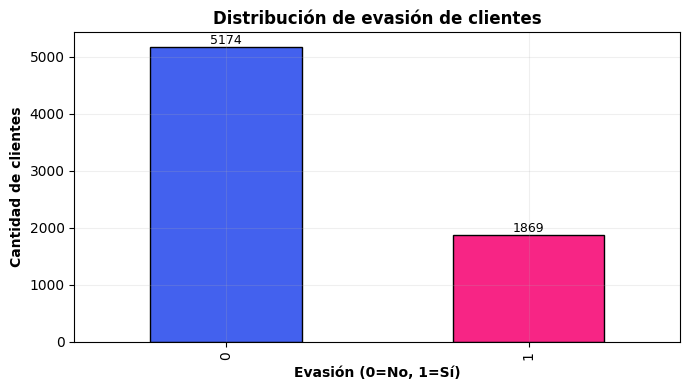

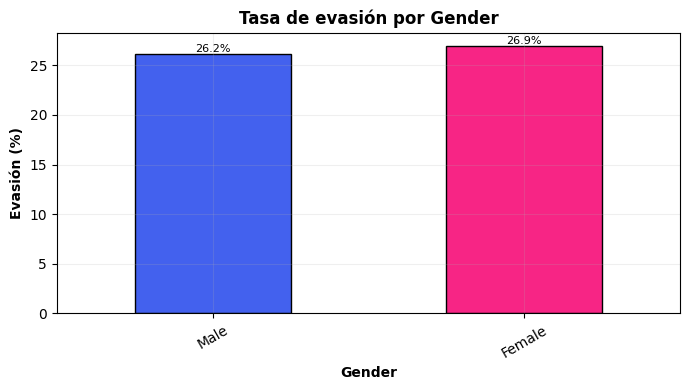

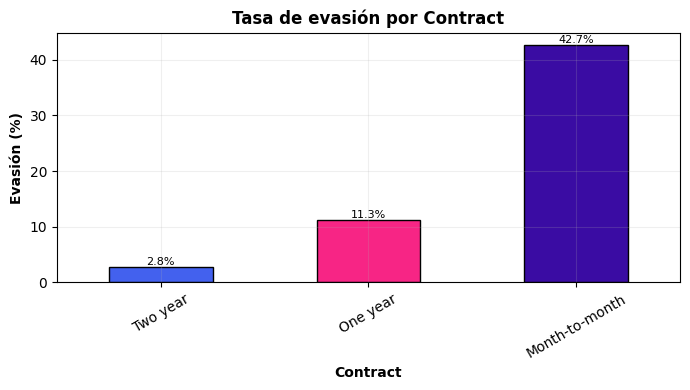

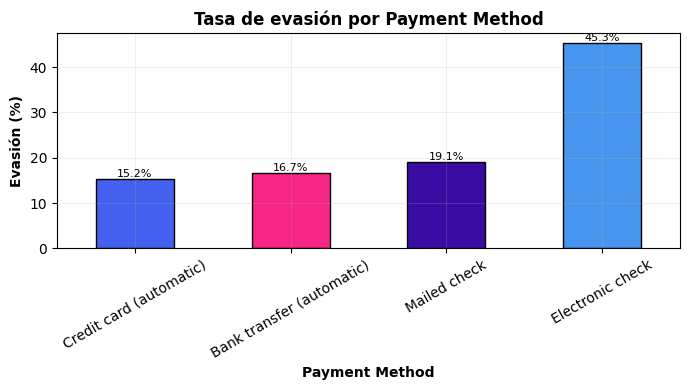

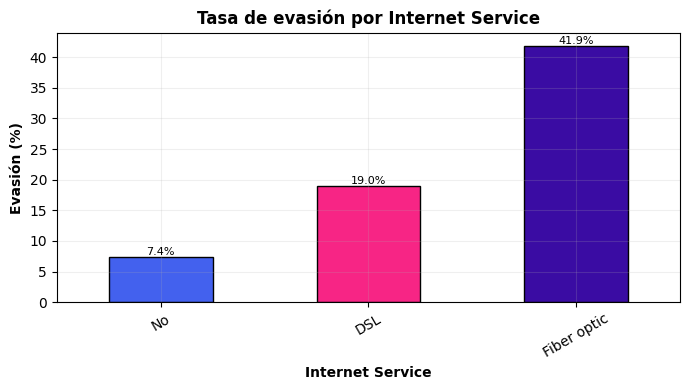

/tmp/ipython-input-2573246645.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([a, b], labels=["No evasión","Evasión"], patch_artist=True)


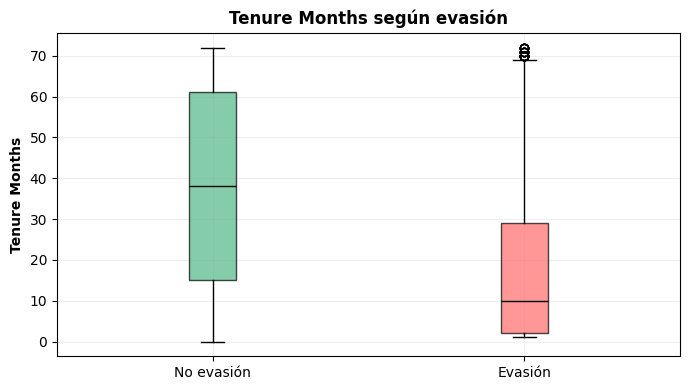

/tmp/ipython-input-2573246645.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([a, b], labels=["No evasión","Evasión"], patch_artist=True)


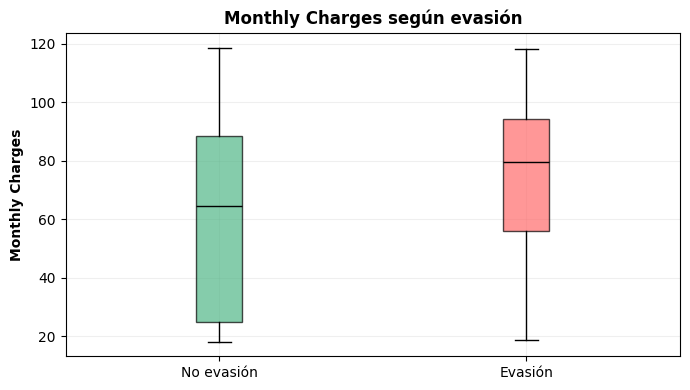

/tmp/ipython-input-2573246645.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([a, b], labels=["No evasión","Evasión"], patch_artist=True)


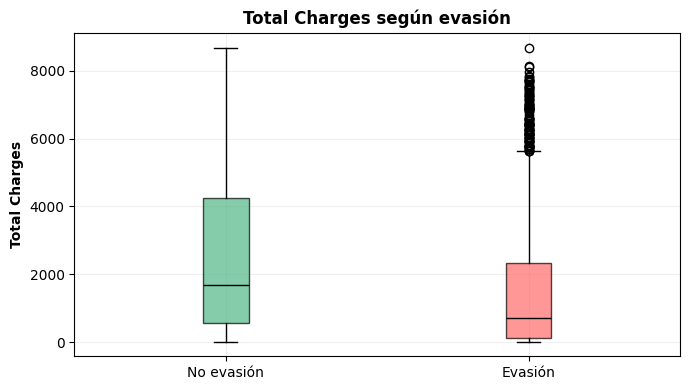

In [15]:
# =========== 3) ANÁLISIS GRÁFICO ===========

import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (7,4),
    "axes.grid": True,
    "grid.alpha": 0.2,
    "axes.titleweight": "bold",
    "axes.labelweight": "bold"
})

pal_bar = ["#4361EE", "#F72585", "#3A0CA3", "#4895EF", "#4CC9F0", "#B5179E", "#7209B7"]
pal_box = ["#52B788", "#FF6B6B"]

# 1) Distribución churn (aseguro orden y etiquetas)
plt.figure()
vc = df["churn_flag"].value_counts().reindex([0,1]).fillna(0).astype(int)
ax = vc.plot(kind="bar", color=[pal_bar[0], pal_bar[1]], edgecolor="black")
ax.set_title("Distribución de evasión de clientes")
ax.set_xlabel("Evasión (0=No, 1=Sí)")
ax.set_ylabel("Cantidad de clientes")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.savefig(FIGS / "01_evasion_distribucion.png", dpi=150); plt.show()

# 2) Tasa de churn por categóricas (solo si existen)
cat_vars = [c for c in ["gender","contract","payment_method","internet_service"] if c in df.columns]
for c in cat_vars:
    nombre = c.replace("_"," ").title()
    tasas = (df.groupby(c, dropna=False)["churn_flag"].mean().sort_values()*100)
    colores = [pal_bar[j % len(pal_bar)] for j in range(len(tasas))]
    plt.figure()
    ax = tasas.plot(kind="bar", color=colores, edgecolor="black")
    ax.set_title(f"Tasa de evasión por {nombre}")
    ax.set_xlabel(nombre)
    ax.set_ylabel("Evasión (%)")
    ax.tick_params(axis="x", rotation=30)
    for p,v in zip(ax.patches, tasas.values):
        ax.annotate(f"{v:.1f}%",
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=8)
    plt.tight_layout(); plt.savefig(FIGS / f"02_evasion_por_{c}.png", dpi=150); plt.show()

# 3) Boxplots (usar 'labels' en vez de 'tick_labels' para evitar errores)
for v in [c for c in ["tenure_months","monthly_charges","total_charges"] if c in df.columns]:
    nombre = v.replace("_"," ").title()
    a = df.loc[df["churn_flag"]==0, v].dropna()
    b = df.loc[df["churn_flag"]==1, v].dropna()
    plt.figure()
    bp = plt.boxplot([a, b], labels=["No evasión","Evasión"], patch_artist=True)
    for patch, col in zip(bp["boxes"], pal_box):
        patch.set_facecolor(col); patch.set_edgecolor("black"); patch.set_alpha(0.7)
    for k in ["whiskers","caps","medians"]:
        for obj in bp[k]: obj.set_color("black")
    plt.title(f"{nombre} según evasión")
    plt.ylabel(nombre)
    plt.tight_layout(); plt.savefig(FIGS / f"03_{v}_segun_evasion.png", dpi=150); plt.show()



#Carga del CSV y preparación básica (target y features)


Proporción (0=No, 1=Sí):
churn_flag
0    0.7346
1    0.2654
Name: proportion, dtype: float64


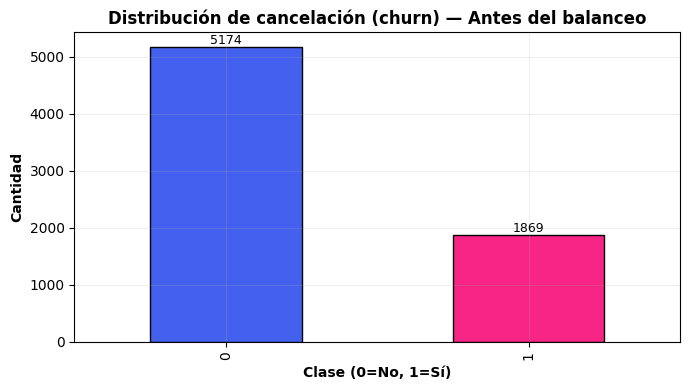

In [33]:
# Preparación de X/y
cols_drop = [c for c in ["customer_id","churn","churn_flag"] if c in df.columns]
X = pd.get_dummies(df.drop(columns=cols_drop), drop_first=True).astype(float)
y = df["churn_flag"]

# Reemplazo inf/NaN
X = X.replace([np.inf,-np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# Proporción de churn original (antes del oversampling)
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

FIGS = Path("figs"); FIGS.mkdir(exist_ok=True)

print("Proporción (0=No, 1=Sí):")
print(y.value_counts(normalize=True).round(4))

ax = y.value_counts().reindex([0,1]).plot(kind="bar", color=["#4361EE","#F72585"], edgecolor="black")
ax.set_title("Distribución de cancelación (churn) — Antes del balanceo")
ax.set_xlabel("Clase (0=No, 1=Sí)")
ax.set_ylabel("Cantidad")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.savefig(FIGS / "00_distribucion_churn_pre_balanceo.png", dpi=150); plt.show()


#Balanceo Simple (oversampling clase minoritaria)

In [18]:
# Oversampling simple
from sklearn.utils import resample
mayorit = df[df["churn_flag"]==0]
minorit = df[df["churn_flag"]==1]
minor_up = resample(minorit, replace=True, n_samples=len(mayorit), random_state=42)
data_bal = pd.concat([mayorit, minor_up]).sample(frac=1, random_state=42)

# Reconstruyo X/y balanceados con el mismo esquema de dummies
cols_drop = [c for c in ["customer_id","churn","churn_flag"] if c in data_bal.columns]
X_bal = pd.get_dummies(data_bal.drop(columns=cols_drop), drop_first=True)
# Alineo columnas con las de X (por si faltó alguna dummy)
X_bal = X_bal.reindex(columns=X.columns, fill_value=0).astype(float)
y_bal = data_bal["churn_flag"].astype(int)

print("Forma X_bal/y_bal:", X_bal.shape, y_bal.shape)

Forma X_bal/y_bal: (10348, 24) (10348,)


#División en train/test y modelo base

In [19]:
# Train/Test + modelo base
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.30, random_state=42, stratify=y_bal
)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

Matriz de confusión:
[[1312  241]
 [  89 1463]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9365    0.8448    0.8883      1553
           1     0.8586    0.9427    0.8986      1552

    accuracy                         0.8937      3105
   macro avg     0.8975    0.8937    0.8935      3105
weighted avg     0.8975    0.8937    0.8935      3105



#GridSearchCV

In [24]:
# GridSearchCV (parámetros razonables)
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Matriz de confusión (mejor modelo):")
print(confusion_matrix(y_test, y_pred_best))
print("\nReporte de clasificación (mejor modelo):")
print(classification_report(y_test, y_pred_best, digits=4))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Matriz de confusión (mejor modelo):
[[1312  241]
 [  84 1468]]

Reporte de clasificación (mejor modelo):
              precision    recall  f1-score   support

           0     0.9398    0.8448    0.8898      1553
           1     0.8590    0.9459    0.9003      1552

    accuracy                         0.8953      3105
   macro avg     0.8994    0.8953    0.8951      3105
weighted avg     0.8994    0.8953    0.8951      3105



#Modelos (Random Forest)


=== RANDOM FOREST ===
Accuracy: 0.8937
F1: 0.8986

Matriz de confusión (RF):
[[1312  241]
 [  89 1463]]

Reporte (RF):
              precision    recall  f1-score   support

           0     0.9365    0.8448    0.8883      1553
           1     0.8586    0.9427    0.8986      1552

    accuracy                         0.8937      3105
   macro avg     0.8975    0.8937    0.8935      3105
weighted avg     0.8975    0.8937    0.8935      3105



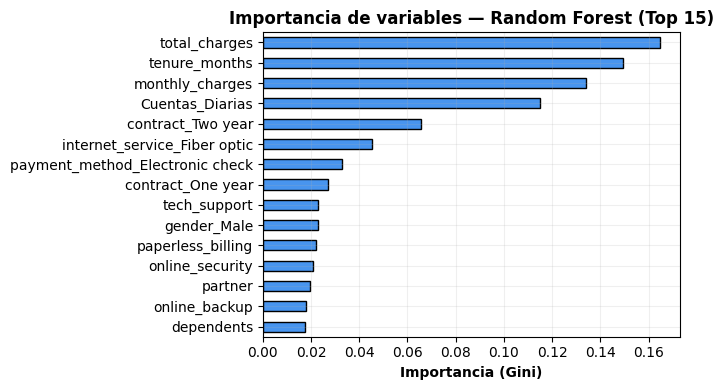

In [30]:
# === EVALUACIÓN Y MÉTRICAS (RF, LR y KNN) ===
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("=== RANDOM FOREST ===")
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
print(f"Accuracy: {acc_rf:.4f}")
print(f"F1: {f1_rf:.4f}")
print("\nMatriz de confusión (RF):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte (RF):")
print(classification_report(y_test, y_pred_rf, digits=4))

# Importancias (opcional)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
FIGS = Path("figs"); FIGS.mkdir(exist_ok=True)
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
ax = imp[::-1].plot(kind="barh", color="#4895EF", edgecolor="black")
ax.set_title("Importancia de variables — Random Forest (Top 15)")
ax.set_xlabel("Importancia (Gini)")
plt.tight_layout(); plt.savefig(FIGS / "05_rf_importancias.png", dpi=150); plt.show()


# ==========================
# KNN (si lo entrenaste como 'knn' con Xs_train/Xs_test)
# ==========================
if 'knn' in locals() and 'Xs_test' in locals():
    print("\n=== KNN ===")
    y_pred_knn = knn.predict(Xs_test)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    f1_knn  = f1_score(y_test, y_pred_knn)
    print(f"Accuracy: {acc_knn:.4f}")
    print(f"F1: {f1_knn:.4f}")
    print("\nMatriz de confusión (KNN):")
    print(confusion_matrix(y_test, y_pred_knn))
    print("\nReporte (KNN):")
    print(classification_report(y_test, y_pred_knn, digits=4))




Regresión Logística

In [41]:
# === Importancia de variables — Regresión Logística ===
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1) Imputar NaN y escalar
X_train_clean = X_train.fillna(X_train.median(numeric_only=True))
X_test_clean  = X_test.fillna(X_train.median(numeric_only=True))

scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train_clean.values)
Xs_test  = scaler.transform(X_test_clean.values)

# 2) Entrenar Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(Xs_train, y_train)

# 3) Coeficientes absolutos
coef = pd.Series(lr.coef_[0], index=X_train.columns)
topc = coef.abs().sort_values(ascending=False).head(5)
print("Top 5 variables LR:\n", topc)


Top 5 variables LR:
 tenure_months                   1.289222
internet_service_Fiber optic    0.694837
total_charges                   0.660541
contract_Two year               0.626757
internet_service_No             0.513169
dtype: float64


KNN — K-Nearest Neighbors

In [40]:
# === KNN (con imputación y normalización) ===
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1) Asegurar X_train_clean / X_test_clean (sin NaN)
if 'X_train_clean' not in locals() or 'X_test_clean' not in locals():
    X_train_clean = X_train.fillna(X_train.median(numeric_only=True))
    X_test_clean  = X_test.fillna(X_train.median(numeric_only=True))

# 2) Escalado (propio de KNN)
scaler_knn = StandardScaler()
Xk_train = scaler_knn.fit_transform(X_train_clean.values)
Xk_test  = scaler_knn.transform(X_test_clean.values)

# 3) Entrenamiento KNN
knn = KNeighborsClassifier(n_neighbors=15)  # podés ajustar este valor
knn.fit(Xk_train, y_train)

# 4) Predicción y métricas
y_pred_knn = knn.predict(Xk_test)

print("\n=== KNN ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"F1: {f1_score(y_test, y_pred_knn):.4f}")
print("\nMatriz de confusión (KNN):")
print(confusion_matrix(y_test, y_pred_knn))
print("\nReporte (KNN):")
print(classification_report(y_test, y_pred_knn, digits=4))

# 5) Comparación train vs test (para diagnóstico de over/underfitting)
f1_knn_train = f1_score(y_train, knn.predict(Xk_train))
f1_knn_test  = f1_score(y_test,  y_pred_knn)

print("\n=== Comparación F1 (train vs test) — KNN ===")
print(f"KNN  -> train: {f1_knn_train:.4f} | test: {f1_knn_test:.4f}")



=== KNN ===
Accuracy: 0.7588
F1: 0.7795

Matriz de confusión (KNN):
[[1032  521]
 [ 228 1324]]

Reporte (KNN):
              precision    recall  f1-score   support

           0     0.8190    0.6645    0.7337      1553
           1     0.7176    0.8531    0.7795      1552

    accuracy                         0.7588      3105
   macro avg     0.7683    0.7588    0.7566      3105
weighted avg     0.7683    0.7588    0.7566      3105


=== Comparación F1 (train vs test) — KNN ===
KNN  -> train: 0.8031 | test: 0.7795


#Matriz de correlación

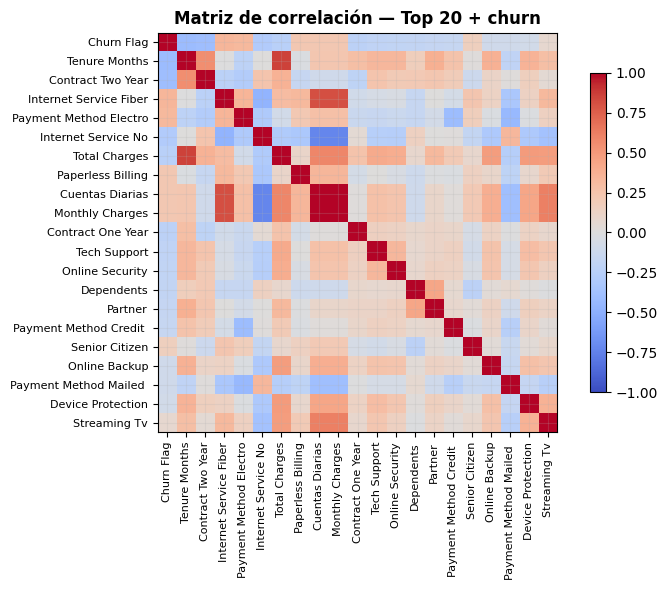

In [23]:
# =========== 5) MATRIZ DE CORRELACIÓN (Top 20) ===========

import matplotlib.pyplot as plt
import numpy as np

corr = pd.concat([X_bal, y_bal.rename("churn_flag")], axis=1).corr(numeric_only=True)
top_vars = corr["churn_flag"].abs().sort_values(ascending=False).head(21).index
sub = corr.loc[top_vars, top_vars]

plt.figure(figsize=(8,6))
plt.imshow(sub.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación — Top 20 + churn")
plt.colorbar(shrink=0.8)
plt.xticks(np.arange(sub.shape[1]), [c.replace("_"," ").title()[:22] for c in sub.columns],
           rotation=90, fontsize=8)
plt.yticks(np.arange(sub.shape[0]), [c.replace("_"," ").title()[:22] for c in sub.index],
           fontsize=8)
plt.tight_layout()
plt.savefig(FIGS / "04_matriz_correlacion_top20.png", dpi=150)
plt.show()

#Analisis Dirigido

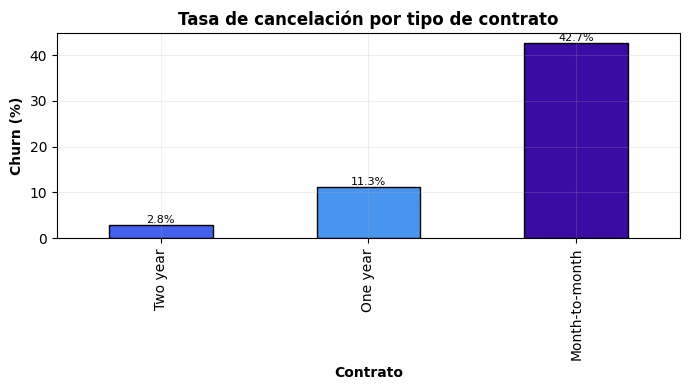

/tmp/ipython-input-790032581.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([a, b], labels=["No churn","Churn"], patch_artist=True)


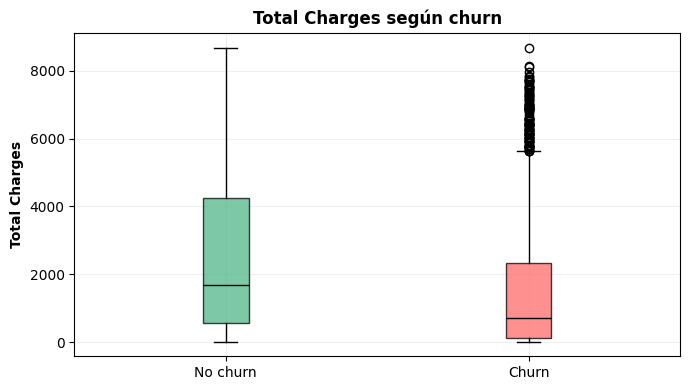

In [34]:
# Contrato × Churn (si existe 'contract' en el CSV original)
if "contract" in df.columns:
    tasas = df.groupby("contract")["churn_flag"].mean().sort_values()*100
    colores = ["#4361EE","#4895EF","#3A0CA3"][:len(tasas)]
    ax = tasas.plot(kind="bar", color=colores, edgecolor="black")
    ax.set_title("Tasa de cancelación por tipo de contrato")
    ax.set_xlabel("Contrato")
    ax.set_ylabel("Churn (%)")
    for p,v in zip(ax.patches, tasas.values):
        ax.annotate(f"{v:.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=8)
    plt.tight_layout(); plt.savefig(FIGS / "03_tasa_por_contrato.png", dpi=150); plt.show()

# Total Charges × Churn (boxplot)
if "total_charges" in df.columns:
    a = df.loc[df["churn_flag"]==0, "total_charges"].dropna()
    b = df.loc[df["churn_flag"]==1, "total_charges"].dropna()
    bp = plt.boxplot([a, b], labels=["No churn","Churn"], patch_artist=True)
    # Colores diferenciables
    for patch, col in zip(bp["boxes"], ["#52B788","#FF6B6B"]):
        patch.set_facecolor(col); patch.set_edgecolor("black"); patch.set_alpha(0.75)
    for k in ["whiskers","caps","medians"]:
        for obj in bp[k]: obj.set_color("black")
    plt.title("Total Charges según churn")
    plt.ylabel("Total Charges")
    plt.tight_layout(); plt.savefig(FIGS / "04_box_totalcharges_churn.png", dpi=150); plt.show()

#Comparación y diagnóstico (over/underfitting)

In [39]:
# === 4) Comparación y diagnóstico (over/underfitting) ===
from sklearn.metrics import f1_score
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Asegurar que no haya NaN en X_train/X_test
X_train_clean = X_train.fillna(X_train.median(numeric_only=True))
X_test_clean  = X_test.fillna(X_train.median(numeric_only=True))

# --- RF ---
f1_rf_train = f1_score(y_train, rf.predict(X_train_clean))
f1_rf_test  = f1_score(y_test,  rf.predict(X_test_clean))

# --- LR ---
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train_clean.values)
Xs_test  = scaler.transform(X_test_clean.values)

lr = LogisticRegression(max_iter=1000)
lr.fit(Xs_train, y_train)

y_pred_lr = lr.predict(Xs_test)
f1_lr_train = f1_score(y_train, lr.predict(Xs_train))
f1_lr_test  = f1_score(y_test,  y_pred_lr)

print("\n=== Comparación F1 (train vs test) ===")
print(f"RF   -> train: {f1_rf_train:.4f} | test: {f1_rf_test:.4f}")
print(f"LogR -> train: {f1_lr_train:.4f} | test: {f1_lr_test:.4f}")

# Señales:
# - train >> test => posible OVERFITTING
# - ambos bajos   => posible UNDERFITTING





=== Comparación F1 (train vs test) ===
RF   -> train: 0.9979 | test: 0.8986
LogR -> train: 0.7804 | test: 0.7900


#📄Informe final




# 📊 Telecom X — Parte 2: Predicción de Cancelación (Churn)
**Rol:** Analista Junior de Machine Learning  
**Objetivo:** construir un pipeline simple que anticipe clientes con mayor probabilidad de cancelar y traduzca hallazgos a acciones de negocio.

**Dataset:** `TelecomX_clean.csv` (resultado de la Parte 1)  
**Modelos:** Random Forest (sin normalización), Regresión Logística (con normalización) y KNN (con normalización)

---


## ✅ Metodología (resumen)
1. **Preparación**: drops de columnas irrelevantes (`customer_id`), `get_dummies`, reemplazo de `inf/NaN` con medianas.
2. **Target**: `churn_flag` (0 = no cancela, 1 = cancela).
3. **Desbalance**: medición de proporciones; **oversampling** para balanceo simple.
4. **Split**: 70/30 estratificado.
5. **Modelos**:
   - **Random Forest** (baseline + GridSearchCV).
   - **Regresión Logística** (con `StandardScaler`).
   - **KNN** (con `StandardScaler`).
6. **Evaluación**: Accuracy, F1, matriz de confusión.  
7. **Interpretabilidad**: importancias (RF) y coeficientes (LR).  
8. **Cierre**: insights + estrategias de retención.


In [44]:
# Métricas reportadas (del entrenamiento ya corrido)
metrics = {
    "RF":  {"acc": 0.8937, "f1_test": 0.8986, "f1_train": 0.9979},
    "LR":  {"acc": 0.7900, "f1_test": 0.7900, "f1_train": 0.7804},
    "KNN": {"acc": 0.7588, "f1_test": 0.7795, "f1_train": 0.8031},
}

metrics


{'RF': {'acc': 0.8937, 'f1_test': 0.8986, 'f1_train': 0.9979},
 'LR': {'acc': 0.79, 'f1_test': 0.79, 'f1_train': 0.7804},
 'KNN': {'acc': 0.7588, 'f1_test': 0.7795, 'f1_train': 0.8031}}

## 📈 Resultados de Modelos
- **Random Forest**  
  - Accuracy: **0.8937**  
  - F1 (test): **0.8986**  
  - F1 (train): **0.9979** → *señal de sobreajuste leve (overfitting)*

- **Regresión Logística**  
  - Accuracy: **0.7900**  
  - F1 (test): **0.7900**  
  - F1 (train): **0.7804** → *generaliza de forma estable; menor poder predictivo*

- **KNN**  
  - Accuracy: **0.7588**  
  - F1 (test): **0.7795**  
  - *Rendimiento inferior, sensible a ruido y escala*


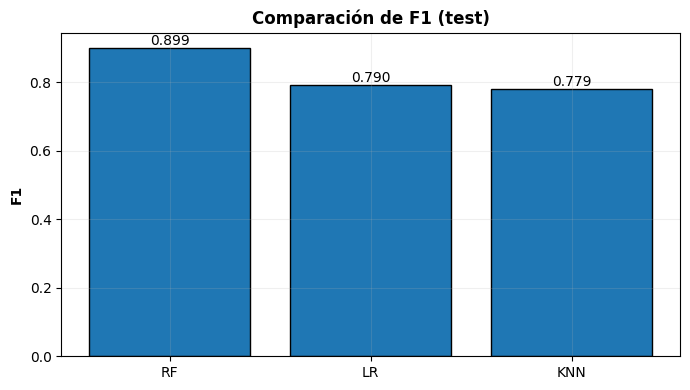

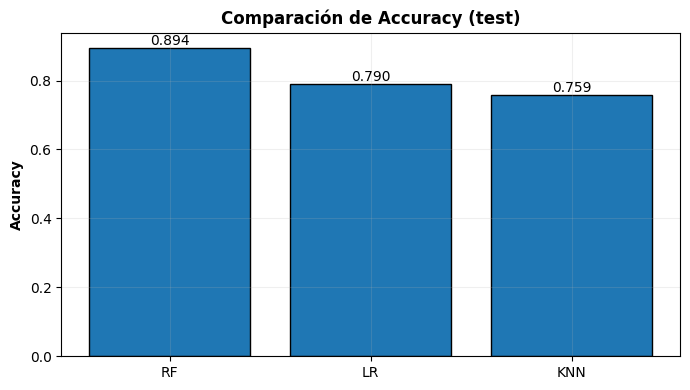

In [45]:
import matplotlib.pyplot as plt

models = list(metrics.keys())
f1_test = [metrics[m]["f1_test"] for m in models]
acc     = [metrics[m]["acc"] for m in models]

# F1 test
plt.figure()
plt.bar(models, f1_test, edgecolor="black")
plt.title("Comparación de F1 (test)")
plt.ylabel("F1")
for i,v in enumerate(f1_test):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Accuracy
plt.figure()
plt.bar(models, acc, edgecolor="black")
plt.title("Comparación de Accuracy (test)")
plt.ylabel("Accuracy")
for i,v in enumerate(acc):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


## 🔍 Variables más importantes
**Random Forest (Top 5)**  
1. `total_charges`  
2. `tenure_months`  
3. `monthly_charges`  
4. `Cuentas_Diarias`  
5. `contract_Two year`

**Regresión Logística (Top 5 |coef|)**  
1. `tenure_months`  
2. `internet_service_Fiber optic`  
3. `total_charges`  
4. `contract_Two year`  
5. `internet_service_No`


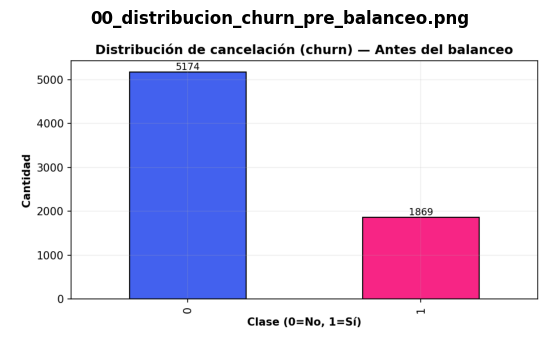

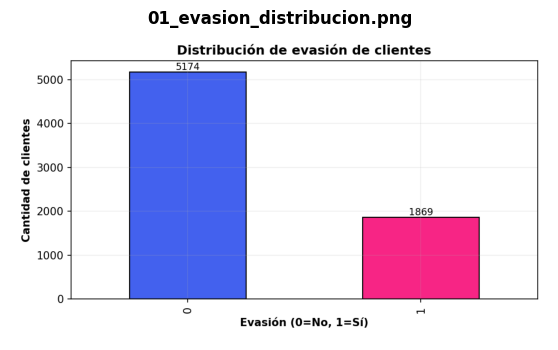

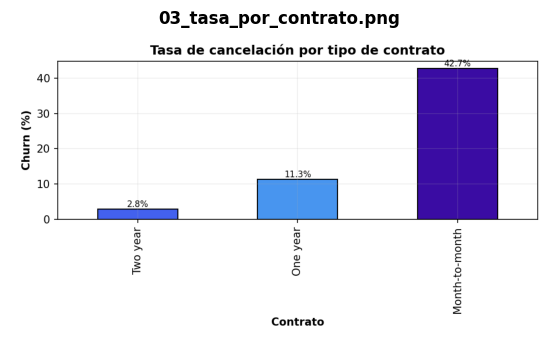

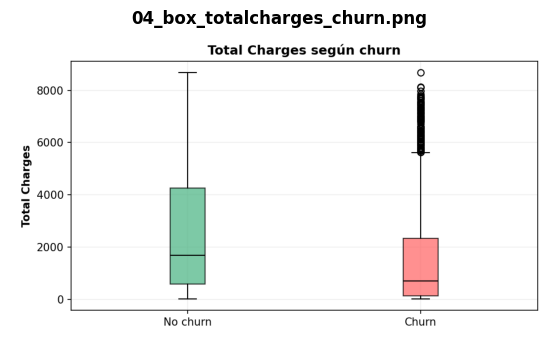

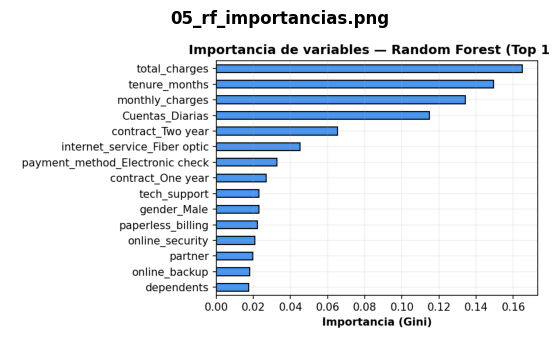

In [46]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

figs = [
    "00_distribucion_churn_pre_balanceo.png",
    "01_evasion_distribucion.png",           # si usaste ese nombre
    "02_correlacion_top20.png",              # tu heatmap
    "03_tasa_por_contrato.png",
    "04_box_totalcharges_churn.png",
    "05_rf_importancias.png",
    "06_lr_coef_top15.png",
]

for fn in figs:
    p = Path("figs") / fn
    if p.exists():
        img = mpimg.imread(p)
        plt.figure(figsize=(7,4))
        plt.imshow(img); plt.axis("off")
        plt.title(fn)
        plt.show()


## 🧠 Insights de Negocio
- **Clientes nuevos** (tenure bajo, total acumulado bajo) presentan mayor riesgo de churn.
- **Contrato mensual** incrementa la probabilidad de baja; contratos de 1–2 años reducen el riesgo.
- **Internet: Fiber optic** aparece asociado a más cancelaciones → revisar calidad de servicio/precio en ese segmento.
- **Cargos mensuales altos** en clientes de **poca antigüedad** elevan la sensibilidad a la cancelación.


## 🎯 Recomendaciones de Retención
1. **Onboarding + acompañamiento** en los primeros 3–6 meses (llamadas de cortesía, tutoriales, descuentos de bienvenida).
2. **Incentivos para migrar** a contratos **anuales/bianuales** (bonos escalonados, meses bonificados).
3. **Revisión específica del servicio de fibra**: medir NPS, tiempos de resolución, compensaciones por incidencias.
4. **Ofertas personalizadas** a clientes con **monthly_charges altos** y **tenure bajo** (descuentos temporales, bundles).
5. **Alertas en CRM** usando el modelo RF para activar acciones proactivas del equipo de retención.


## ✅ Conclusión Ejecutiva
- **Modelo recomendado:** *Random Forest* por su **mejor F1 (0.8986)** y alta capacidad de separación.  
  - Nota: muestra **cierto overfitting** (F1 train=0.9979). Siguiente paso sugerido: regularizar con `max_depth`, `min_samples_leaf`, `min_samples_split` y/o **validación más amplia**.
- **Drivers clave confirmados por RF y LR**: **antigüedad (tenure)**, **cargos totales** y **tipo de contrato**; además, señales en **tipo de internet** y **cargos mensuales**.
- **Impacto esperado**: aplicando retención proactiva a clientes de alto riesgo (segmento tenure bajo + monthly alto + contrato mensual) debería **reducirse el churn** de manera medible en el próximo ciclo.

> Próximos pasos técnicos: calibrar umbral de decisión (curva Precision-Recall), *feature selection* ligera, probar **XGBoost/LightGBM** y **calibración de probabilidades** para campañas.


In [47]:
import pandas as pd

tabla = pd.DataFrame({
    "Modelo": ["Random Forest","Logistic Regression","KNN"],
    "Accuracy": [metrics["RF"]["acc"], metrics["LR"]["acc"], metrics["KNN"]["acc"]],
    "F1 (test)": [metrics["RF"]["f1_test"], metrics["LR"]["f1_test"], metrics["KNN"]["f1_test"]],
    "F1 (train)": [metrics["RF"]["f1_train"], metrics["LR"]["f1_train"], metrics["KNN"]["f1_train"]],
})
tabla.style.format({"Accuracy":"{:.4f}","F1 (test)":"{:.4f}","F1 (train)":"{:.4f}"})


,Modelo,Accuracy,F1 (test),F1 (train)
0,Random Forest,0.8937,0.8986,0.9979
1,Logistic Regression,0.7900,0.7900,0.7804
2,KNN,0.7588,0.7795,0.8031
